In [1]:
#The code below was developed by Rodrigo A. Dourado, a PhD student at the University of Sao Paulo at São Carlos co-supervised 
#by Prof. J. Carlos Egues and Dr. Poliana H. Penteado. The results obtained via this code were also independently checked by additional 
#Mathematica and Python codes for particular cases developed by Dr Penteado.
#This code is not for distribution. 

In [2]:
#import os
#os.environ["OMP_NUM_THREADS"] = "1"
#os.environ["MKL_NUM_THREADS"] = "1"
#os.environ["OPENBLAS_NUM_THREADS"] = "1"
#os.environ["NUMEXPR_NUM_THREADS"] = "1"
#os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy import linalg as LA
import random
import numpy.matlib
import kwant
import tinyarray
import multiprocessing as mp
import os
from tqdm import tqdm
import helpers as hp
from pathlib import Path
from config import PathConfigs
import scipy.sparse.linalg as sla
import multiprocessing as mp
from functools import partial
from scipy.signal import find_peaks

#pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [4]:
def calculate_local_mp(syst_closed):
    """
    Calculates the Local Majorana Polarization (Mj) for each site j.
    Formula: M_j = (2 * u * v) / (u^2 + v^2)
    Adapted for spinful wire: Sums spin contributions per site.
    
    Returns:
    - M_profile: Array of length L (number of sites), containing Mj for each site.
    - energy_0: The energy of the analyzed mode.
    """
    ham = syst_closed.hamiltonian_submatrix(sparse=True)
    try:
        evals, evecs = sla.eigsh(ham, k=2, sigma=0, which='LM')
    except:
        evals, evecs = np.linalg.eigh(ham.toarray())
        
    idx = np.argsort(np.abs(evals))
    psi = evecs[:, idx[0]]
    energy_0 = evals[idx[0]]

    
    n_sites = len(psi) // 4
    psi_sites = psi.reshape(n_sites, 4)
    
    
    # Basis (u_up, u_down, v_down, -v_up)
    u_up   = psi_sites[:, 0]
    u_down = psi_sites[:, 1]
    v_down = psi_sites[:, 2]
    v_up   = -psi_sites[:, 3]
    

    overlap = u_up * np.conj(v_up) + u_down * np.conj(v_down)
    numerator = 2 * np.real(overlap)
    
    denominator = (np.abs(u_up)**2 + np.abs(u_down)**2 + 
                   np.abs(v_down)**2 + np.abs(v_up)**2)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        M_profile = numerator / denominator
        
    M_profile = np.nan_to_num(M_profile) # Replace NaNs with 0
    
    return M_profile, energy_0

In [5]:
def calculate_gamma_squared(syst_closed, k=0):
    """
    Calculates the 'Squared Majorana Operator' value for the k-th energy mode.
    Formula: gamma^2 = Sum_j (u_j * v_j)
    
    Parameters:
    - syst_closed: finalized system (without leads attached).
    - k: The index of the eigenstate
    """
    ham = syst_closed.hamiltonian_submatrix(sparse=True)
    try:
        evals, evecs = sla.eigsh(ham, k=k+4, sigma=0, which='LM')
    except:
        evals, evecs = np.linalg.eigh(ham.toarray())
        
    idx = np.argsort(np.abs(evals))
    psi = evecs[:, idx[k]]  # Wavefunction of the k-th mode
    
    #basis order: (e_up, e_down, h_down, h_up) per site
    
    n_tot = len(psi)
    u_vec = psi[:n_tot//2]  
    v_vec = psi[n_tot//2:]  
    
    gamma_sq = np.sum(u_vec * v_vec)
    
    return gamma_sq

In [6]:
def build_system_closed(t, mu, mu_n, Delta, V_z, alpha, Ln, Lb, Ls, mu_leads, barrier_l, barrier_r, Vdisx = None, a = 1):
    
    
    syst = kwant.Builder()
    lat = kwant.lattice.square(a, norbs=4)

    #lead
    sym_left_lead = kwant.TranslationalSymmetry((-a, 0))
    sym_right_lead = kwant.TranslationalSymmetry((a, 0))
    
    
    left_lead = kwant.Builder(sym_left_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    right_lead = kwant.Builder(sym_right_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    
    #print(f"left lead type: {type(left_lead)}")
    #print(f"right lead type: {type(right_lead)}")
    #print(f"syst type: {type(syst)}")
    

    #Here one can edit the chemical potential profile. The profile below is for the quasi-Majorana case, the pristine case would be 
    # mu_s[i] = mu, and for disorder we use mu_s[i] = mu + (some random value)
    # For the nontopological ABS (dotted magenta curve in Figs. 2 c and d), set alpha = 0 in the central region and add a 
    # Zeeman energy on the normal segments of the wire.
    
    mu_s = np.zeros(Ls)
    if Vdisx is None:
        Vdisx  = np.zeros_like(mu_s)
        
    
    for i in range(Ls):
        mu_s[i] = mu + Vdisx[i] #- (mu - mu_n) * (1 - np.tanh(i/80))    

    for i in range(Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_l) * np.kron(sigma_z, sigma_0)
        if i > 0:
            syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
            
    for i in range(Lb, Lb+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
        
    for i in range(Lb+Ln, Lb+Ln+Ls):
        syst[lat(i, 0)] = (2 * t - mu_s[i-Lb-Ln]) * np.kron(sigma_z, sigma_0) + Delta * np.kron(sigma_x, sigma_0) + V_z * np.kron(sigma_0, sigma_x)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
        
    for i in range(Lb+Ln+Ls, Lb+Ln+Ls+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
        
    for i in range(Lb+Ln+Ls+Ln, Lb+Ln+Ls+Ln+Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_r) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
    

    return syst.finalized()

In [7]:
def build_system(t, mu, mu_n, Delta, V_z, alpha, Ln, Lb, Ls, mu_leads, barrier_l, barrier_r, Vdisx = None, a = 1):
    
    
    syst = kwant.Builder()
    lat = kwant.lattice.square(a, norbs=4)

    #lead
    sym_left_lead = kwant.TranslationalSymmetry((-a, 0))
    sym_right_lead = kwant.TranslationalSymmetry((a, 0))
    
    
    left_lead = kwant.Builder(sym_left_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    right_lead = kwant.Builder(sym_right_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    
    #print(f"left lead type: {type(left_lead)}")
    #print(f"right lead type: {type(right_lead)}")
    #print(f"syst type: {type(syst)}")
    

    #Here one can edit the chemical potential profile. The profile below is for the quasi-Majorana case, the pristine case would be 
    # mu_s[i] = mu, and for disorder we use mu_s[i] = mu + (some random value)
    # For the nontopological ABS (dotted magenta curve in Figs. 2 c and d), set alpha = 0 in the central region and add a 
    # Zeeman energy on the normal segments of the wire.
    
    mu_s = np.zeros(Ls)
    if Vdisx is None:
        Vdisx  = np.zeros_like(mu_s)
        
    
    for i in range(Ls):
        mu_s[i] = mu + Vdisx[i] #- (mu - mu_n) * (1 - np.tanh(i/80))    

    for i in range(Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_l) * np.kron(sigma_z, sigma_0)
        if i > 0:
            syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
            
    for i in range(Lb, Lb+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
        
    for i in range(Lb+Ln, Lb+Ln+Ls):
        syst[lat(i, 0)] = (2 * t - mu_s[i-Lb-Ln]) * np.kron(sigma_z, sigma_0) + Delta * np.kron(sigma_x, sigma_0) + V_z * np.kron(sigma_0, sigma_x)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
        
    for i in range(Lb+Ln+Ls, Lb+Ln+Ls+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
        
    for i in range(Lb+Ln+Ls+Ln, Lb+Ln+Ls+Ln+Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_r) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
    

    left_lead[lat(0, 0)] = (2 * t - mu_leads) * np.kron(sigma_z, sigma_0) 
    left_lead[lat(1, 0), lat(0, 0)] = -t * np.kron(sigma_z, sigma_0)
    right_lead[lat(0, 0)] = (2 * t - mu_leads) * np.kron(sigma_z, sigma_0) 
    right_lead[lat(1, 0), lat(0, 0)] = -t * np.kron(sigma_z, sigma_0)

    syst.attach_lead(left_lead)
    syst.attach_lead(right_lead)
    return syst.finalized()

In [ ]:
#To generate Figs 1 and 2 one first sets the parameters

t = 102.0
mu = 0.76
mu_n = 0.2
mu_leads = 20.0
Delta = 0.5
alpha = 3.5
Ln = 20 # normal metal length
Lb = 4 #barrier length
Ls = 500 #super conductor length

totlen = Ln + Lb +Ls 
V_c = np.sqrt(mu**2 + Delta**2)
#V_z = 1.0 * V_c # To generate Fig 2a V_z should be varied. For the cyan line in Fig 2, for example, V_z = 1.203 * V_c  
V_z = 1.2#0.9 * V_c 
barrier_l = 5
points = 100
barrier_r = np.linspace(barrier_l, 40*barrier_l, points) #Varying the right barrier U_R
lambda_dis = 1/0.222  #unit cell lengeth is about 20% the decay length of the disorder
V0 = 10.5 * Delta #setting disorder amplitude from paper relateive to SC-gap
a=1


num_engs = 101 
energies = np.linspace(-0.5, 0.5, num_engs)
#Vdisx = hp.generate_1d_Vdis(Ls, a, 52, V0, lambda_dis) 
 
fname = "med_dis_data/nontopological/nontopo-zbp-corr-badldos/Data.npz"
path = "/home/pseudonym/code/Nonlocal_Conductance/Nonlocality-of-local-Andreev-conductances-as-a-probe-for-topological-Majorana-wires/Run_Files/Data.npz"
Vdisx = hp.initialize_vdis_from_data(path) * V0







In [9]:
#vzs = np.linspace(0.6, 1.6, 100)
#partial_calc = partial(
#        hp.calculate_pdi, 
#        t, mu, Delta,           # Positional args before V_z
#        alpha=alpha,            # Keyword args after V_z
#        Ls=Ls, 
#        Vdisx=-Vdisx,           # Ensure the negative sign is kept
#        q_N=1
#    )
#num_processes = mp.cpu_count() - 2
#
#with mp.Pool(processes=num_processes) as pool:
#    results = pool.map(partial_calc, vzs)
#    
#pdi_arr = np.array(results)

In [10]:
##Original Conductance Curve Code
#Andreev_downup = np.zeros(points)
#Andreev_upup = np.zeros(points)
#Andreev_updown = np.zeros(points)
#Andreev_downdown = np.zeros(points)
#
#conductance_left = np.zeros(points)
#conductance_right = np.zeros(points)
#
#for k in range(points):
#    #print(f"running point: {k}/{points}")
#    syst = build_system(
#        t=t, 
#        mu=mu, 
#        mu_n=mu_n, 
#        Delta=Delta, 
#        V_z=V_z, 
#        alpha=alpha, 
#        Ln=Ln, 
#        Lb=Lb, 
#        Ls=Ls, 
#        mu_leads=mu_leads, 
#        barrier_l=barrier_l, 
#        barrier_r=barrier_r[k],
#        Vdisx = Vdisx,
#        a=1
#        )
#    
#    smatrix = kwant.smatrix(syst, 0.0)
#    #Calculating the conductance
#    R = 0
#    A = 0
#    for i in range(2):
#        for j in range(2):
#            R = R + smatrix.transmission((0, j), (0, i))
#            A = A + smatrix.transmission((0, j+2), (0, i))
#    conductance_left[k] = 2 - R + A
#    R = 0
#    A = 0
#    for i in range(2):
#        for j in range(2):
#            R = R + smatrix.transmission((1, j), (1, i))
#            A = A + smatrix.transmission((1, j+2), (1, i))
#    conductance_right[k] = 2 - R + A
#    
#    #Individual Andreev reflection components on the left side
#    Andreev_downup[k] = smatrix.transmission((0, 2), (0, 0))
#    Andreev_upup[k] = smatrix.transmission((0, 3), (0, 0))
#    Andreev_downdown[k] = smatrix.transmission((0, 2), (0, 1))
#    Andreev_updown[k] = smatrix.transmission((0, 3), (0, 1))

In [11]:
G_matrix_barrier = np.zeros(shape=(points, 2, 2))

#Original Conductance Curve Code
Andreev_downup = np.zeros(points)
Andreev_upup = np.zeros(points)
Andreev_updown = np.zeros(points)
Andreev_downdown = np.zeros(points)

conductance_left = np.zeros(points)
conductance_right = np.zeros(points)

for k in range(points):
    #print(f"running point: {k}/{points}")
    syst = build_system(
        t=t, 
        mu=mu, 
        mu_n=mu_n, 
        Delta=Delta, 
        V_z=V_z, 
        alpha=alpha, 
        Ln=Ln, 
        Lb=Lb, 
        Ls=Ls, 
        mu_leads=mu_leads, 
        barrier_l=barrier_l, 
        barrier_r=barrier_r[k],
        Vdisx = Vdisx,
        a=1
        )
    
    smatrix = kwant.smatrix(syst, 0.0)
    #print(f"running energy {k}/{num_engs}")
    Rl = 0
    Al = 0
    Rr = 0
    Ar = 0
    # Non-Local Transmissions
    T_RL = 0; TA_RL = 0 # Left -> Right
    T_LR = 0; TA_LR = 0 # Right -> Left
    for i in range(2):
        for j in range(2):
            Rl = Rl + smatrix.transmission((0, j), (0, i))
            Al = Al + smatrix.transmission((0, j+2), (0, i))

            Rr = Rr + smatrix.transmission((1, j), (1, i))
            Ar = Ar + smatrix.transmission((1, j+2), (1, i))
            
            T_RL  += smatrix.transmission((1, j),   (0, i)) # Normal
            TA_RL += smatrix.transmission((1, j+2), (0, i)) # Crossed Andreev
            T_LR  += smatrix.transmission((0, j),   (1, i)) # Normal
            TA_LR += smatrix.transmission((0, j+2), (1, i)) # Crossed Andreev
            
            
    G_matrix_barrier[k,0,0] = 2 - Rr + Ar
    G_matrix_barrier[k,1,1] = 2 - Rl + Al
    
    G_matrix_barrier[k, 1, 0] = TA_RL - T_RL # Current at Right (1) due to Left (0)
    G_matrix_barrier[k, 0, 1] = TA_LR - T_LR # Current at Left (0) due to Right (1)
    
    

    conductance_right = G_matrix_barrier[:,0,0]
    conductance_left  = G_matrix_barrier[:,1,1]
    
    #Individual Andreev reflection components on the left side
    Andreev_downup[k] = smatrix.transmission((0, 2), (0, 0))
    Andreev_upup[k] = smatrix.transmission((0, 3), (0, 0))
    Andreev_downdown[k] = smatrix.transmission((0, 2), (0, 1))
    Andreev_updown[k] = smatrix.transmission((0, 3), (0, 1))

In [12]:
#### calculating ZBP using kwant (Original)
#num_engs = 201
#energies = np.linspace(-0.5, 0.5, num_engs)
#dIdV_left = np.zeros_like(energies)
#dIdV_right = np.zeros_like(energies)
#
#ldos = np.zeros(shape = (num_engs, 2192))
##using symmetric barrier for now
#syst = build_system(
#    t=t, 
#    mu=mu, 
#    mu_n=mu_n, 
#    Delta=Delta, 
#    V_z=V_z, 
#    alpha=alpha, 
#    Ln=Ln, 
#    Lb=Lb, 
#    Ls=Ls, 
#    mu_leads=mu_leads, 
#    barrier_l=barrier_l, 
#    barrier_r=barrier_l, 
#    Vdisx = Vdisx,
#    a=1
#    )
#
#for k, eng in tqdm(enumerate(energies), total=num_engs, desc="Calculating differential Conductance"):
#    #print(f"running energy {k}/{num_engs}")
#    eng = energies[k]
#    smatrix = kwant.smatrix(syst, eng)
#    Rl = 0
#    Al = 0
#    Rr = 0
#    Ar = 0
#    T_he = 0
#    T_ee = 0
#    for i in range(2):
#        for j in range(2):
#            Rl = Rl + smatrix.transmission((0, j), (0, i))
#            Al = Al + smatrix.transmission((0, j+2), (0, i))
#
#            Rr = Rr + smatrix.transmission((1, j), (1, i))
#            Ar = Ar + smatrix.transmission((1, j+2), (1, i))
#            
#            
#            
#    dIdV_right[k] = 2 - Rr + Ar
#    dIdV_left[k] = 2 - Rl + Al
#    
#    ldos[k,:] = kwant.ldos(syst, eng)
#    
#    
   

In [13]:
### calculating ZBP using kwant


dIdV_left = np.zeros_like(energies)
dIdV_right = np.zeros_like(energies)
G_matrix = np.zeros(shape=(num_engs, 2, 2))

ldos = np.zeros(shape = (num_engs, 2192))
#using symmetric barrier for now
syst = build_system(
    t=t, 
    mu=mu, 
    mu_n=mu_n, 
    Delta=Delta, 
    V_z=V_z, 
    alpha=alpha, 
    Ln=Ln, 
    Lb=Lb, 
    Ls=Ls, 
    mu_leads=mu_leads, 
    
    barrier_l=barrier_l, 
    barrier_r=barrier_l, 
    Vdisx = Vdisx,
    a=1
    )

syst_closed = build_system_closed(
    t=t, 
    mu=mu, 
    mu_n=mu_n, 
    Delta=Delta, 
    V_z=V_z, 
    alpha=alpha, 
    Ln=Ln, 
    Lb=Lb, 
    Ls=Ls, 
    mu_leads=mu_leads, 
    barrier_l=barrier_l, 
    barrier_r=barrier_l, 
    Vdisx = Vdisx,
    a=1
    )


for k, eng in tqdm(enumerate(energies), total=num_engs, desc="Calculating differential Conductance"):
    #print(f"running energy {k}/{num_engs}")
    eng = energies[k]
    smatrix = kwant.smatrix(syst, eng)
    Rl = 0
    Al = 0
    Rr = 0
    Ar = 0
    
    # Non-Local Transmissions
    T_RL = 0; TA_RL = 0 # Left -> Right
    T_LR = 0; TA_LR = 0 # Right -> Left
    
    for i in range(2):
        for j in range(2):
            Rl = Rl + smatrix.transmission((0, j), (0, i))
            Al = Al + smatrix.transmission((0, j+2), (0, i))

            Rr = Rr + smatrix.transmission((1, j), (1, i))
            Ar = Ar + smatrix.transmission((1, j+2), (1, i))
            
            T_RL  += smatrix.transmission((1, j),   (0, i)) # Normal
            TA_RL += smatrix.transmission((1, j+2), (0, i)) # Crossed Andreev
            T_LR  += smatrix.transmission((0, j),   (1, i)) # Normal
            TA_LR += smatrix.transmission((0, j+2), (1, i)) # Crossed Andreev
            
            
    G_matrix[k, 0,0] = 2 - Rl + Al
    G_matrix[k, 1,1] = 2 - Rr + Ar
    
    G_matrix[k, 1, 0] = TA_RL - T_RL # Current at Right (1) due to Left (0)
    G_matrix[k, 0, 1] = TA_LR - T_LR # Current at Left (0) due to Right (1)
    
    
    #dIdV_right[k] = 2 - Rr + Ar
    #dIdV_left[k]  = 2 - Rl + Al
    dIdV_right = G_matrix[:,0,0]
    dIdV_left  = G_matrix[:,1,1]
    ldos[k,:] = kwant.ldos(syst, eng)
    
    
   

Calculating differential Conductance: 100%|██████████| 101/101 [00:22<00:00,  4.40it/s]


In [14]:
Data_dir = Path("/home/pseudonym/code/Nonlocal_Conductance/Nonlocality-of-local-Andreev-conductances-as-a-probe-for-topological-Majorana-wires/Data")
save_dir = Path(Data_dir/"New_Results")
os.makedirs(save_dir, exist_ok=True)

Disorder Mean: -2.842170943040401e-17


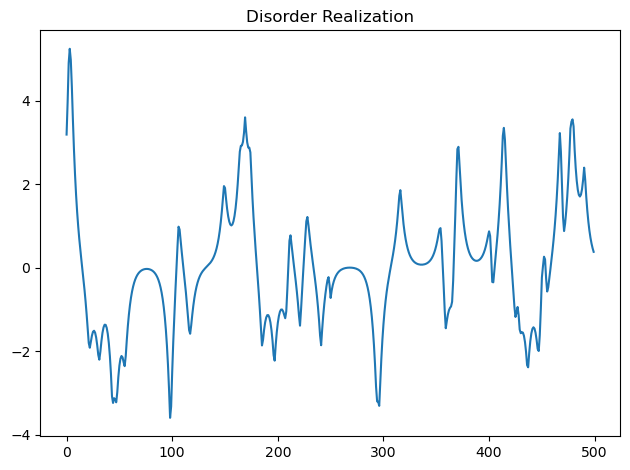

In [15]:
plt.plot(Vdisx)
plt.title("Disorder Realization")
plt.tight_layout()
plt.savefig(Path(save_dir/"Vdisx.png"))
print(f"Disorder Mean: {np.mean(Vdisx)}")

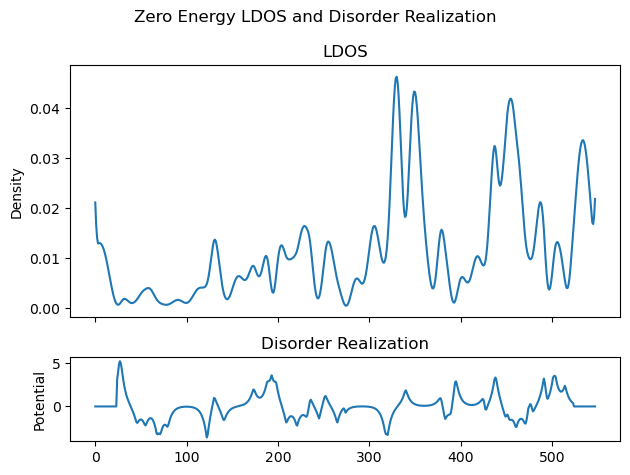

In [16]:
import matplotlib.pyplot as plt
import numpy as np

ldos_per_site = ldos.reshape(num_engs, -1, 4).sum(axis=2)
site_positions = [site.pos[0] for site in syst.sites]

# ... (Previous data generation code: energies, Vz_var, dIdVs_left_arr, etc.) ...


# Update: 3 rows, height ratios [3, 1, 1] to make ax2 and ax3 equal size
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Plot 1: Heatmap ---
ax1.plot(ldos_per_site[100,:])
ax1.set_ylabel("Density") 
ax1.set_title("LDOS")

# --- Plot 2: MZM Polarization (Top Line Plot) ---
ax2.plot(np.pad(Vdisx, (24, 24), mode = 'constant'))
ax2.set_ylabel("Potential")
#ax2.legend() # Optional: added legend since there are two lines
ax2.set_title("Disorder Realization")


fig.suptitle(r"Zero Energy LDOS and Disorder Realization")
fig.tight_layout()

plt.show()

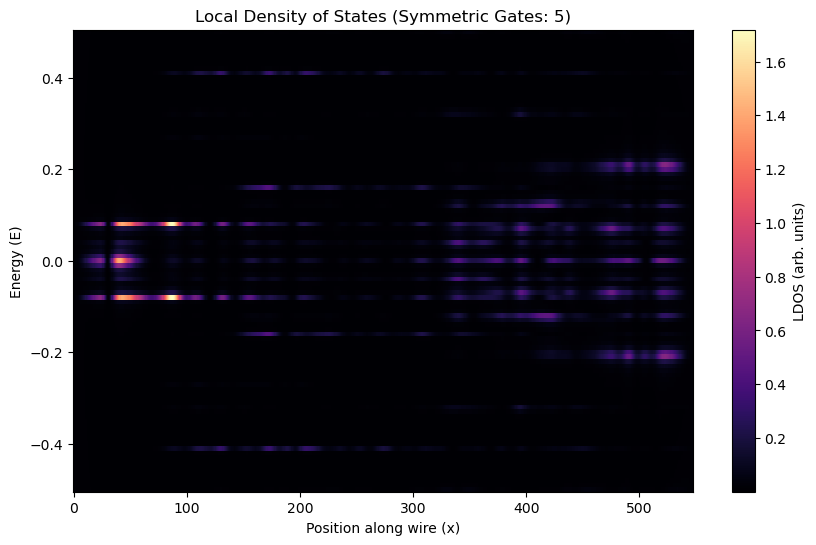

In [17]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(site_positions, energies)

plt.figure(figsize=(10, 6))
# Plotting LDOS vs Energy and Position
plt.pcolormesh(X, Y, ldos_per_site, cmap='magma', shading='auto')
plt.colorbar(label='LDOS (arb. units)')
plt.xlabel('Position along wire (x)')
plt.ylabel('Energy (E)')
plt.title(f'Local Density of States (Symmetric Gates: {barrier_l})')
plt.savefig(Path(save_dir/"total_ldos.png"))
plt.show()

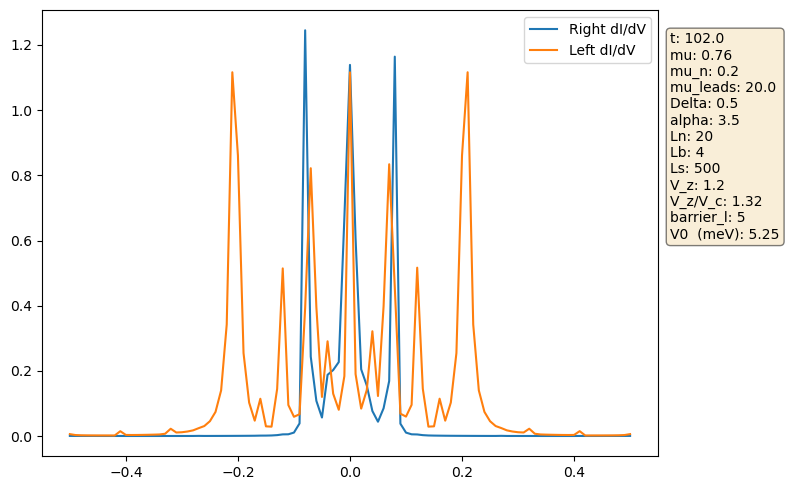

In [18]:
params = {
"t" :t, 
"mu" :mu, "mu_n" :mu_n, 
"mu_leads" :mu_leads, 
"Delta" :Delta, 
"alpha" :alpha, 
"Ln":Ln,
"Lb":Lb,
"Ls":Ls,
"V_z":V_z,
"V_z/V_c":f"{(V_z/V_c):.2f}",
"barrier_l":barrier_l,
"V0  (meV)": f"{V0:.2f}",

}


text_str = '\n'.join([f"{key}: {val}" for key, val in params.items()])


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(energies, dIdV_right, label="Right dI/dV")
ax.plot(energies, dIdV_left, label="Left dI/dV")


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.text(1.02, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
ax.legend()
fig.tight_layout()
fig.savefig(Path(save_dir/"dIdV.png"))

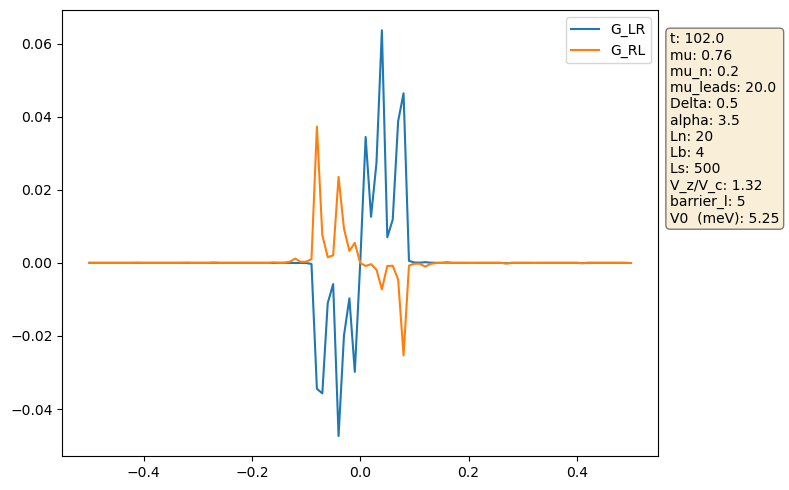

In [19]:
params = {
"t" :t, 
"mu" :mu, "mu_n" :mu_n, 
"mu_leads" :mu_leads, 
"Delta" :Delta, 
"alpha" :alpha, 
"Ln":Ln,
"Lb":Lb,
"Ls":Ls,
"V_z/V_c":f"{(V_z/V_c):.2f}",
"barrier_l":barrier_l,
"V0  (meV)": V0,

}

G_LR = G_matrix[:, 0, 1]
G_RL = G_matrix[:, 1, 0]


text_str = '\n'.join([f"{key}: {val}" for key, val in params.items()])


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(energies, G_LR, label="G_LR")
ax.plot(energies, G_RL, label="G_RL")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax.text(1.02, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
ax.legend()
fig.tight_layout()
fig.savefig(Path(save_dir/"nonlocaldIdV.png"))

New Correlation: 1.9119297184334296
old Correlation: 0.994739108926491


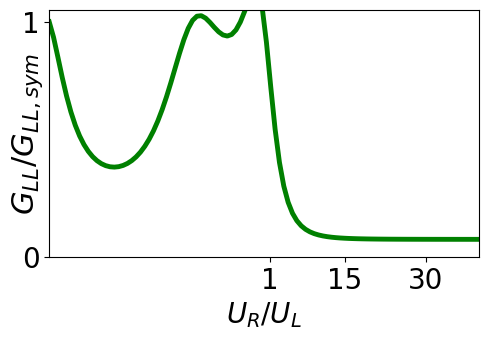

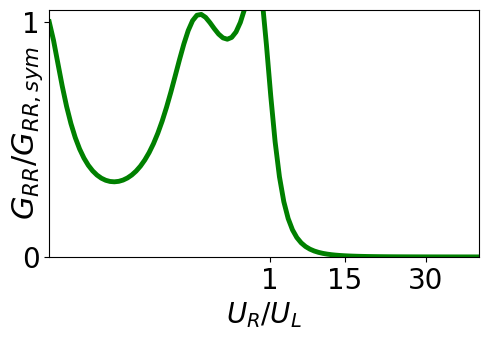

In [29]:
# This can be used to plot the many cases explored in Figs 1 and 2. 
# For Figs. 2a and 2b, one just needs to change the variables accordingly, barrier_r -> V_z and instead of the conductance 
# plot the Andreev reflection components calculated above

fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

lw = 3.5

normed_GL = conductance_left/conductance_left[0]
normed_GR = conductance_right/conductance_right[0]
corr = np.dot(normed_GR, normed_GL)/(np.linalg.norm(normed_GR)*np.linalg.norm(normed_GL))
corr_new = hp.calc_invariant_metric(normed_GL, normed_GR)

print(f"New Correlation: {corr_new}")
print(f"old Correlation: {corr}")

axes.plot(barrier_r, normed_GL, color="green", linewidth=lw)
axes.set_xlim(barrier_r[0], barrier_r[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L} $", fontsize=20)
axes.set_ylabel(r"$G_{LL}/G_{LL, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)

fig.tight_layout()
fig.savefig(Path(save_dir/"Conductances_Left.png"))
fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

axes.plot(barrier_r, normed_GR, color="green", linewidth=lw)
axes.set_xlim(barrier_r[0], barrier_r[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L}$", fontsize=20)
axes.set_ylabel(r"$G_{RR}/G_{RR, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)
fig.tight_layout()
fig.savefig(Path(save_dir/"Conductances_Right.png"))

In [21]:
##plotting non local conductances
#
#fig, axes = plt.subplots(1,1, figsize=(5,3.5))
#fig.subplots_adjust(0,0,1,1)
#
#lw = 3.5
#
#G_LR_barrier = G_matrix_barrier[:, 0, 1]
#G_RL_barrier = G_matrix_barrier[:, 1, 0]
#
#axes.plot(barrier_r, G_LR_barrier/G_LR_barrier[0], color="green", linewidth=lw)
#axes.set_xlim(barrier_r[0], barrier_r[-1])
#axes.set_ylim(0, 1.05)
#axes.set_yticks([0, 1])
#axes.set_yticklabels([0, 1], fontsize=20)
#axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
#axes.set_xticklabels([1, 15, 30], fontsize=20)
#axes.set_xlabel(r"$U_{R}/U_{L} $", fontsize=20)
#axes.set_ylabel(r"$G_{LR}/G_{LR, sym}$", fontsize=22)
#axes.yaxis.set_label_coords(-0.01, 0.5)
#
#fig.tight_layout()
#fig.savefig(Path(save_dir/"G_LR_barrier.png"))
#fig, axes = plt.subplots(1,1, figsize=(5,3.5))
#fig.subplots_adjust(0,0,1,1)
#
#axes.plot(barrier_r, G_RL_barrier/G_RL_barrier[0], color="green", linewidth=lw)
#axes.set_xlim(barrier_r[0], barrier_r[-1])
#axes.set_ylim(0, 1.05)
#axes.set_yticks([0, 1])
#axes.set_yticklabels([0, 1], fontsize=20)
#axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
#axes.set_xticklabels([1, 15, 30], fontsize=20)
#axes.set_xlabel(r"$U_{R}/U_{L}$", fontsize=20)
#axes.set_ylabel(r"$G_{RL}/G_{RL, sym}$", fontsize=22)
#axes.yaxis.set_label_coords(-0.01, 0.5)
#fig.tight_layout()
#fig.savefig(Path(save_dir/"G_RL_barrier.png"))
#
###G_LR_barrier
###G_RL_barrier
#

In [22]:
##Saving Data
np.savez(Path(save_dir/"Data.npz"), 
         conductance_right = conductance_right, 
         conductance_left = conductance_left, 
         dIdV_left = dIdV_left,
         dIdV_right = dIdV_right,
         energies = energies,
         ldos_per_site = ldos_per_site,
         Vdisx = Vdisx,
         G_matrix = G_matrix,
         G_matrix_barrier = G_matrix_barrier
         
         )

np.savez(Path(save_dir/"Parameters.npz"),
         
        t = t,
        mu = mu,
        mu_n = mu_n,
        mu_leads = mu_leads,
        Delta = Delta,
        alpha = alpha,
        Ln = Ln,
        Lb = Lb,
        Ls = Ls,
        V_c = V_c,
        V_z = V_z,
        barrier_l = barrier_l,
        points = points,
        barrier_r = barrier_r,
        lambda_dis = lambda_dis,
        V0 = V0,
         )

In [23]:
def lorentzian(x, x0, gamma, A):
    """
    Calculates the values for a Lorentzian peak.
    
    Parameters:
    x (array): The x-axis data points.
    x0 (float): The center of the peak.
    gamma (float): The half-width at half-maximum (HWHM).
    A (float): The maximum amplitude of the peak.
    """
    return A * (gamma**2 / ((x - x0)**2 + gamma**2))

In [24]:
# 1. Define the x-axis values
# Creating 500 points between -10 and 10 for a smooth curve
x = np.linspace(-10, 10, 1001)

center1 = 4.0    # Centered at x = 0
width1 = 0.2   # Gamma (width of the peak)
amplitude1 = 10.0  # Max height

center2 = 0.5    # Centered at x = 0
width2 = 0.4  # Gamma (width of the peak)
amplitude2 = 9.5  # Max height


y1 = lorentzian(x, x0=center1, gamma=width1, A=amplitude1) + lorentzian(x, x0=-center1, gamma=width1, A=amplitude1)
y2 = lorentzian(x, x0=center2, gamma=width2, A=amplitude2) + lorentzian(x, x0=-center2, gamma=width2, A=amplitude2) + y1

In [25]:
def detect_ZBP(x, y, prominence = 0.05):
    find_peaks(y1, prominence = 0.05)

In [26]:
z_idx= np.where(x == 0)

z_idx

(array([500]),)

In [27]:
f = y2

range = 5
pos_rng_idx = np.where(np.isclose(x, range))[0][0]
neg_rng_idx = np.where(np.isclose(x, -range))[0][0]

f = f[neg_rng_idx:pos_rng_idx]
x_filt = x[neg_rng_idx:pos_rng_idx]

ret = find_peaks(f, prominence = 0.05)
peak_idxs = ret[0]
peak_values = ret[1]['prominences']
peak_x_vals = x_filt[peak_idxs]





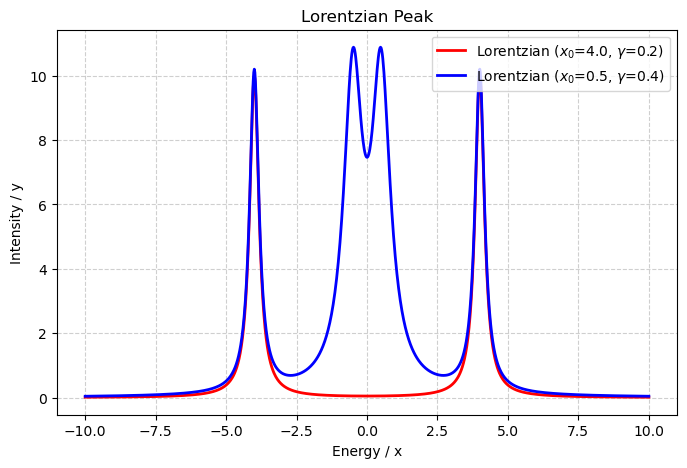

In [28]:
# 4. Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, y1, label=f'Lorentzian ($x_0$={center1}, $\gamma$={width1})', color='red', linewidth=2)
plt.plot(x, y2, label=f'Lorentzian ($x_0$={center2}, $\gamma$={width2})', color='blue', linewidth=2)

# Formatting the plot
plt.title('Lorentzian Peak')
plt.xlabel('Energy / x')
plt.ylabel('Intensity / y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()